In [1]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists

import matplotlib; # matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from model import FullyConnected, BayesianRegression

from viz import (
    get_coverage_bounds,
    plot_1d_posterior_predictive,
    get_uncertainty_in_gap,
    plot_basis_functions_1d,
    compute_eff_dim,
)

from util import *

import warnings
warnings.filterwarnings("ignore")

# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# set training data
N = 20
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.2).sample((N//2, 1)), dists.Uniform(0.2, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)

# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 50000

# architecture and activation
ACTIVATION = nn.ReLU
num_final_layers = 10

all_num_first_layer_nodes = [2, 5, 10, 20, 50, 100, 200] * 5
all_eff_dims = []
all_uncertainties = []

for num_first_layer_nodes in all_num_first_layer_nodes:
    
    layers = [1, num_first_layer_nodes, num_final_layers, 1]

    # define a neural network feature basis and final layer
    basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
    final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

    # define MLE loss
    def mle_loss():
        y_pred = final_layer(basis(x_train))
        loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))

        return loss, (basis, final_layer)

    # randomly initialize basis and last layer
    basis.rand_init(math.sqrt(w_prior_var))
    final_layer.rand_init(math.sqrt(w_prior_var))
    
    # optimize loss to learn network
    (basis, final_layer), loss = train_objective(
        list(basis.parameters()) + list(final_layer.parameters()),
        mle_loss,
        lr=LEARNING_RATE,
        print_freq=1000
    )
    
    # infer posterior over the last layer weights given the basis
    posterior, posterior_mean = model.infer_posterior(basis(x_train), y_train)
    
    # # sample from posterior predictive
    x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
    y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

    # visualize posterior predictive
#     %matplotlib inline
#     plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)
    uncertainty = get_uncertainty_in_gap(model, basis, x_train, y_train, 500)
    all_uncertainties.append(uncertainty)
    
    x_vals = np.linspace(-1, 1, 3000)
#     basis_vals = plot_basis_functions_1d(num_final_layers, x_vals, basis, x_train, posterior_mean, numcols=12)
    basis_vals = basis(torch.tensor(x_vals.reshape(-1, 1)))
    
    eff_dim = compute_eff_dim(basis_vals, z=1)
    all_eff_dims.append(eff_dim)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.3
  UserWarning)


Epoch 0: loss = 0.3053163137495848
Epoch 1000: loss = 0.008511745233514304
Epoch 2000: loss = 0.004976933869732468
Epoch 3000: loss = 0.004752442755691414
Final Loss = 0.004641831290774903
Epoch 0: loss = 0.49916247231459654
Epoch 1000: loss = 0.007663177678245045
Epoch 2000: loss = 0.007378617415273718
Epoch 3000: loss = 0.0070915817487578955
Final Loss = 0.006948733768612328
Epoch 0: loss = 1.167409648912061
Epoch 1000: loss = 0.014990645936698382
Epoch 2000: loss = 0.004003858890220884
Epoch 3000: loss = 0.0023707618774735585
Final Loss = 0.002017171876735887
Epoch 0: loss = 4.974556614234603
Epoch 1000: loss = 0.0267191271537359
Epoch 2000: loss = 0.00967072445104851
Epoch 3000: loss = 0.006297734164870372
Final Loss = 0.005976684535821601
Epoch 0: loss = 333.01021520442384
Epoch 1000: loss = 0.021986444468697366
Epoch 2000: loss = 0.015386291167737662
Epoch 3000: loss = 0.0122682578289892
Final Loss = 0.010418672822454851
Epoch 0: loss = 26.379096398530965
Epoch 1000: loss = 0.005

In [2]:
df = pd.DataFrame({"num_first_layer_nodes": all_num_first_layer_nodes, "eff_dim": all_eff_dims, "uncertainty": all_uncertainties})
df.head(10)

,num_first_layer_nodes,eff_dim,uncertainty
0,2,1.947921,0.227346
1,5,2.271153,0.324303
2,10,1.292223,0.324031
3,20,1.938333,0.557224
4,50,2.508050,0.695178
5,100,1.772254,0.388470
6,200,2.258786,0.635805
7,2,1.431392,0.223048
8,5,1.432714,0.226510
9,10,2.296439,0.503931


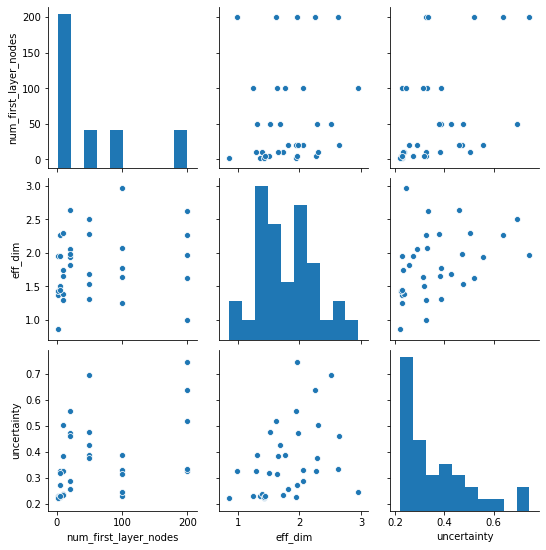

In [3]:
sns.pairplot(df)
plt.savefig("2-14-pairplot-eff_dim_uncertainty_first_layer_nodes")
plt.show()